In [1]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import EvaluatePredictions
from PREDICT.Metrics import Accuracy, AUROC, AUPRC, F1Score, Precision, Recall, Sensitivity, Specificity, OE, CITL, CoxSnellR2, CalibrationSlope
from PREDICT.Triggers import AccuracyThreshold
from PREDICT.Plots import CalibrationSlopePlot, AccuracyPlot, CITLPlot, CoxSnellPlot

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import importlib


### COVID shock change

In [2]:
# Initialize dictionary
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list(),
    'age': list(),
    'systolic_bp': list(),
    'flu_symptoms': list()
}

# Set random seed for reproducibility
np.random.seed(42)

# Define date range and COVID shock periods
startDate = pd.to_datetime('01-01-2020', dayfirst=True)
endDate = pd.to_datetime('31-12-2020', dayfirst=True)
switchDate = pd.to_datetime('01-03-2020', dayfirst=True)  # COVID starts spreading
switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
numdays = (endDate - startDate).days
switchDays = (switchDate - startDate).days
switch2Days = (switchDate2 - startDate).days

# Generate baseline variables for 5000 individuals
age = np.random.normal(70, 5, 5000)  # Mean age 70 years, std 5
systolic_bp = np.random.normal(120, 10, 5000)  # Mean systolic blood pressure 120 mmHg, std 10

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)
    
    # Calculate baseline log-odds
    lp = -1.5 + 0.5 * (age - 70) / 5 + 2 * (systolic_bp - 120) / 10
    curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability
    
    # Simulate COVID effects
    if i >= switchDays:
        lp += 1.5  # Increase incidence due to initial COVID impact
    if i >= switch2Days:
        lp += 2.0  # Further increase as the pandemic peaks
    
    # Simulate flu symptoms
    if i < switchDays:
        flu_symptoms = np.random.binomial(1, 0.1, 5000)  # Low baseline prevalence
    elif i < switch2Days:
        flu_symptoms = np.random.binomial(1, 0.3, 5000)  # Increased prevalence during COVID spread
    else:
        flu_symptoms = np.random.binomial(1, 0.5, 5000)  # Higher prevalence during pandemic peak
    
    # Generate outcomes
    curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate "heart attack" events
    
    # Append to dictionary
    mydict['date'].extend([curday] * 5000)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)
    mydict['age'].extend(age)
    mydict['systolic_bp'].extend(systolic_bp)
    mydict['flu_symptoms'].extend(flu_symptoms)

# Create a DataFrame
df = pd.DataFrame(mydict)

# Display dataset summary
print(df.head())


        date  outcome  prediction        age  systolic_bp  flu_symptoms
0 2020-01-01        0    0.109178  72.483571   115.762403             0
1 2020-01-01        0    0.077561  69.308678   115.465859             0
2 2020-01-01        0    0.008430  73.238443   102.043568             0
3 2020-01-01        0    0.198028  77.615149   116.699098             0
4 2020-01-01        1    0.462218  68.829233   127.328291             0


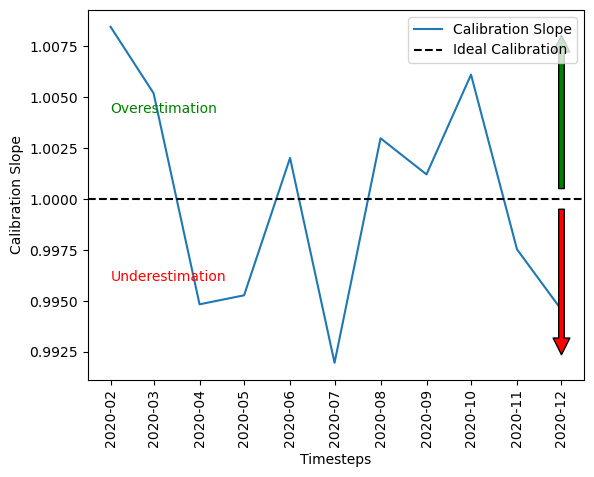

In [3]:

from PREDICT import Plots
importlib.reload(Plots)
from PREDICT.Plots import CalibrationSlopePlot

model = EvaluatePredictions()
#model.trigger = AccuracyThreshold(model=model, threshold=0.7)

mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='month')
mytest.addLogHook(Accuracy(model))
mytest.addLogHook(CalibrationSlope(model))
mytest.addLogHook(CITL(model))
mytest.run()
log = mytest.getLog()
#AccuracyPlot(log)
CalibrationSlopePlot(log)

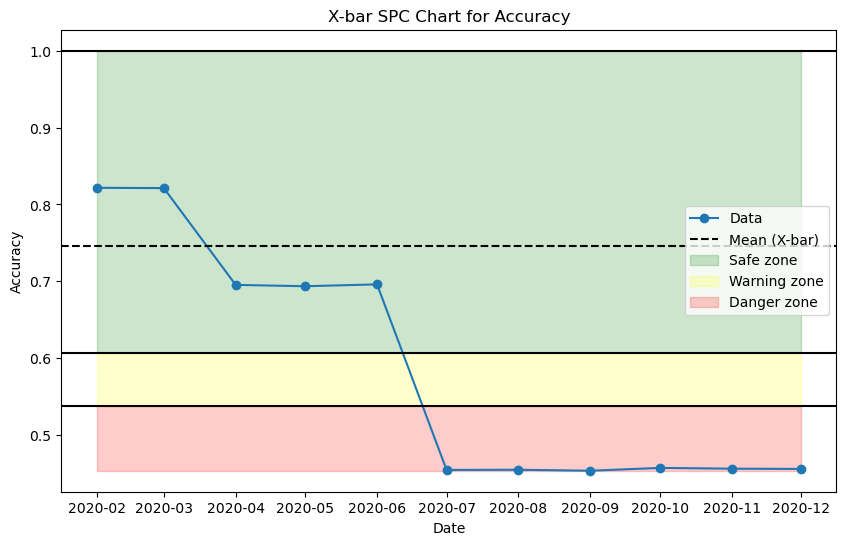

Accuracy is in the danger zone (-3 standard deviations from the mean). Investigate the cause of the decrease and recalibrate the model.


In [14]:
# X-bar chart to monitor changes to accuracy over time


# Select a period of time to calculate the LCLs from
startLCLDate = pd.to_datetime('01-01-2020', dayfirst=True)
endLCLDate = pd.to_datetime('01-06-2020', dayfirst=True)


accuracy_df = pd.DataFrame(list(log['Accuracy'].items()), columns=['Date', 'Accuracy'])
accuracy_df['Date'] = pd.to_datetime(accuracy_df['Date'])

lcl_calc_df = accuracy_df[(accuracy_df['Date'] >= startLCLDate) & (accuracy_df['Date'] <= endLCLDate)]


mean = lcl_calc_df['Accuracy'].mean()
std_dev = lcl_calc_df['Accuracy'].std()
ucl = 1

l2sdl = mean - 2 * std_dev
l3sdl = mean - 3 * std_dev
lcl = min(mean - 4 * std_dev, accuracy_df['Accuracy'].min())

# Plot
plt.figure(figsize=(10, 6))
plt.plot(accuracy_df['Date'], accuracy_df['Accuracy'], marker='o', label='Data')
plt.axhline(mean, color='black', linestyle='--', label='Mean (X-bar)')

plt.axhline(ucl, color='black', linestyle='-')
plt.axhline(l2sdl, color='black', linestyle='-')
plt.axhline(l3sdl, color='black', linestyle='-')

plt.fill_between(accuracy_df['Date'], ucl, l2sdl, color='green', alpha=0.2, label='Safe zone')
plt.fill_between(accuracy_df['Date'], l2sdl, l3sdl, color='yellow', alpha=0.2, label='Warning zone')
plt.fill_between(accuracy_df['Date'],  lcl, l3sdl, color='red', alpha=0.2, label='Danger zone')

plt.title('X-bar SPC Chart for Accuracy')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()

if accuracy_df['Accuracy'].min() < l2sdl and accuracy_df['Accuracy'].min() > l3sdl:
    print('Accuracy is in the warning zone (-2 standard deviations from the mean). Investigate the cause of the decrease.')
if accuracy_df['Accuracy'].min() < l3sdl:
    print('Accuracy is in the danger zone (-3 standard deviations from the mean). Investigate the cause of the decrease and recalibrate the model.')

# TODO Need to decide when the recalibrate the model automatically


In [5]:
# P-bar SPC chart to monitor changes to flu symptoms prevalence over time



In [6]:
# X-bar SPC chart to monitor changes to age demographic distribution over time

